We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticLCS folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/EllipticLCS")

# Overview

In the following notebook we extract elliptic Lagrangian coherent structures (elliptic LCS) from a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
2. Define computational parameters (such as the number of cores) and variables.
3. Define spatio-temporal domain.
4. Interpolate velocity from the (discrete) gridded data.
5. Elliptic LCS:

    Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
   
    Compute Cauchy Green (CG) strain tensor as: 
    
    \begin{equation} \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0)^T\mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0). \tag{1} \end{equation}
    
    Elliptic LCSs are closed null geodesics of the one-parameter family of Lorentzian metrics:
    
    \begin{equation}
        \mathrm{A_{\mathrm{\lambda}}(\mathbf{x}_0)} = \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) - \lambda^2\mathbf{I} \tag{2}
    \end{equation}
    
    The parameter $ \lambda \in \mathbb{R} $ denotes the averaged tangential stretching over the time-interval $ [t_0, t_N] $ along an elliptic LCS. For perfectly coherent elliptic LCS it holds $ \lambda = 1  $.  
    
    We denote:
    \begin{equation}
        \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \begin{pmatrix} C^{11} && C^{12} \\ C^{12} && C^{22}\end{pmatrix} \tag{3}
    \end{equation}
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \tag{4} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A_{\lambda}(\mathbf{x}_0) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A_{\lambda}(\mathbf{x}_0) \mathbf{e}_{\phi}(s) \rangle}, \label{eq: RHS_2} \tag{5}
    \end{align} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $.
    
   <img src="attachment:ClosedNullGeodesic.png" width="500">
   
    The term $ \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x}_0 $ and on $ \phi $, but not on $ \lambda $ and can be evaluated through interpolation over the spatial meshgrid (X, Y) as well as over $ \phi \in [0, 2\pi] $. 
    
    It holds:
    \begin{equation}
    \dfrac{d \phi}{ds} = - \dfrac{\cos^2(\phi)[C_x^{11}(\mathbf{x}_0)\cos(\phi)+C_y^{11}(\mathbf{x}_0)\sin(\phi)]+[C_x^{12}(\mathbf{x}_0)\cos(\phi)+C_y^{11}(\mathbf{x}_0)\sin(\phi)]\sin(2\phi)+\sin^2(\phi)[C_x^{22}(\mathbf{x}_0)\cos(\phi)+C_y^{22}(\mathbf{x}_0)\sin(\phi)]}{\sin(2\phi)[C^{22}(\mathbf{x}_0)-C^{11}(\mathbf{x}_0)]+2\cos(2\phi)C^{12}(\mathbf{x}_0)} \tag{6}
    \end{equation}
    
    The set of initial conditions is given by (see also [init_level_set](../../EllipticLCS/init_level_set.ipynb)):
    
    \begin{equation}
        (\mathbf{x}_0, \phi_0)_{\lambda} = \lbrace (\mathbf{x}_0(\lambda, \phi_0 = 0), 0) \in V: C^{11}(\mathbf{x}_0)- \lambda^2 = 0 \rbrace \tag{7}
    \end{equation}
    
    Furthermore the domain of existence of the ODE is restricted to points $ \mathbf{x}_0, \phi $ where:
    
   \begin{equation}
       \sin(2\phi)[C^{22}(\mathbf{x}_0)-C^{11}(\mathbf{x}_0)]+2\cos(2\phi)C^{12}(\mathbf{x}_0) \neq 0 \label{eq: DOE} \tag{8}
   \end{equation}
   
   If the trajectory violates condition $ \ref{eq: DOE} $, then the integration is stopped. In order to be evaluate the RHS of equation \ref{eq: RHS_2}, we need to interpolate the Cauchy-Green strain tensor over the whole domain. 
   
6. Advect Elliptic LCS

7. Elliptic LCS on FTLE

    The outermost elliptic LCS is visualized together with the $ \mathrm{FTLE} $-field.
    
8. References

# Import data

In [2]:
# import scipy
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 3

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# Time step-size (in days)
dt = .1

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # len(time) = N

# Length of time interval (in days)
lenT = abs(tN-t0)

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -24

# Make sure that the chosen domain is part of the data domain
# make sure that the spatio-temporal you defined are within the domain of the data
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# Spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Ny = X_domain.shape[0]
Nx = X_domain.shape[1]

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy]

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

  0%|          | 0/92 [00:00<?, ?it/s]

# Elliptic LCS

## Cauchy Green (CG) strain tensor

The Cauchy Green strain tensor $ C_{t_0}^t(\mathbf{x}) $ is computing by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid.

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package for computing CauchyGreen (CG) strain tensor
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_C(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, Nx*Ny, 2, 2)

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # shape (N, 2, 2, Nx*Ny)

    # Compute CG
    C = gradFmap_t0_tN.copy()*np.nan
    for i in range(gradFmap_t0_tN.shape[2]):
        C[:,:,i] = CauchyGreen(gradFmap_t0_tN[:,:,i]) # shape (2, 2, Nx*Ny)
    
    return C

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_C)(x0_batch[i], y0_batch[i]) for i in tqdm(range(len(x0_batch))))

# Extract CG tensor from results of parallel computing
C = results[0]

for res in results[1:]:
    C = np.append(C, res, axis = 2)
    
# Reshape array from vectorized form to structured meshgrid
C = C.reshape((2, 2, X_domain.shape[0], X_domain.shape[1]))

### Note that this step here is optional
# In order to suppress numerical noise arising from the computations of derivatives of the Cauchy Green strain tensor,
# we can apply a spatial average filter on the Cauchy Green strain tensor

# kernel_size of spatial average filter
kernel_size = 3

def filter_CauchyGreenStrain(C):
    
    C_filter = C.copy()
    
    for i in range(C.shape[2]):
        for ii in range(C.shape[3]):
            kernel_size_low_y = max(i-kernel_size, 0)
            kernel_size_up_y = min(i+kernel_size+1, Ny)
            kernel_size_low_x = max(ii-kernel_size, 0)
            kernel_size_up_x = min(ii+kernel_size+1, Nx)
            if len(C[0,0,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel()) > 0:
                C_filter[0,0,i,ii] = np.nanmean(C[0,0,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
                C_filter[0,1,i,ii] = np.nanmean(C[0,1,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
                C_filter[1,0,i,ii] = C[0,1,i,ii]
                C_filter[1,1,i,ii] = np.nanmean(C[1,1,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
    return C_filter
            
C = filter_CauchyGreenStrain(C.copy())

  0%|          | 0/3 [00:00<?, ?it/s]

## Interpolate Cauchy-Green strain tensor

In [8]:
# Import eigenvalue/eigenvector calculator
from ipynb.fs.defs.eigen import eigen

# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute elements of CG tensor
C11 = C[0,0,:,:].copy()
C12 = C[0,1,:,:].copy()
C22 = C[1,1,:,:].copy()
    
# Interpolate elements of CG tensor (per default: linear)
interp_C11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(C11, nan=0.0), kx = 3, ky = 3)
interp_C12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(C12, nan=0.0), kx = 3, ky = 3)
interp_C22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(C22, nan=0.0), kx = 3, ky = 3)

# Initialize gradients of CG tensor
C11x = np.zeros((C11.shape[0], C11.shape[1]))*np.nan
C11y = np.zeros((C11.shape[0], C11.shape[1]))*np.nan
C12x = np.zeros((C11.shape[0], C11.shape[1]))*np.nan
C12y = np.zeros((C11.shape[0], C11.shape[1]))*np.nan
C22x = np.zeros((C11.shape[0], C11.shape[1]))*np.nan
C22y = np.zeros((C11.shape[0], C11.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]/2
rho_y = aux_grid[1]/2
        
#iterate over meshgrid to compute gradients of CG tensor
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        C11x[i, j] = (interp_C11(x[1], x[0]+rho_x)[0][0]-interp_C11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C11y[i, j] = (interp_C11(x[1]+rho_y, x[0])[0][0]-interp_C11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        C12x[i, j] = (interp_C12(x[1], x[0]+rho_x)[0][0]-interp_C12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C12y[i, j] = (interp_C12(x[1]+rho_y, x[0])[0][0]-interp_C12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        C22x[i, j] = (interp_C22(x[1], x[0]+rho_x)[0][0]-interp_C22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C22y[i, j] = (interp_C22(x[1]+rho_y, x[0])[0][0]-interp_C22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

## Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [9]:
# import function to interpolate phi_prime
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant of phi_phrime (interp_phi_prime) 
interp_phi_prime = _phi_prime(X_domain, Y_domain, C11, C12, C22, C11x, C11y, C12x, C12y, C22x, C22y)[0]

## Compute elliptic LCS

In [17]:
# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# Define lambda range
lam_min = 0.8
lam_max = 1.2
n_lam = 3*Ncores
lam_range = np.linspace(lam_min, lam_max, n_lam)

# Threshold distance between starting and return point of trajectory
d_threshold = dx/10

# compute elliptic LCS
def compute_elliptic_LCS(lam):
    
    # Define list storing x, y coordinates of elliptic LCS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_lam = closed_null_geodesics(X_domain, Y_domain, lam, interp_phi_prime, d_threshold, C11, iteration_length = 12, n_iterations = 4000, verbose = True)
     
    x_elliptic, y_elliptic = [], []
    # iterate over all geodesics
    for NG in closed_NG:
        
        if np.sum(NG[0]) is not None:
            
            x = NG[0]
            y = NG[1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            
            x_elliptic.append(x)
            y_elliptic.append(y)
    
    return [x_elliptic, y_elliptic, init_lam]
        
# compute elliptic LCS with parallel computing
Elliptic_LCS = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_elliptic_LCS)(i) for i in lam_range)

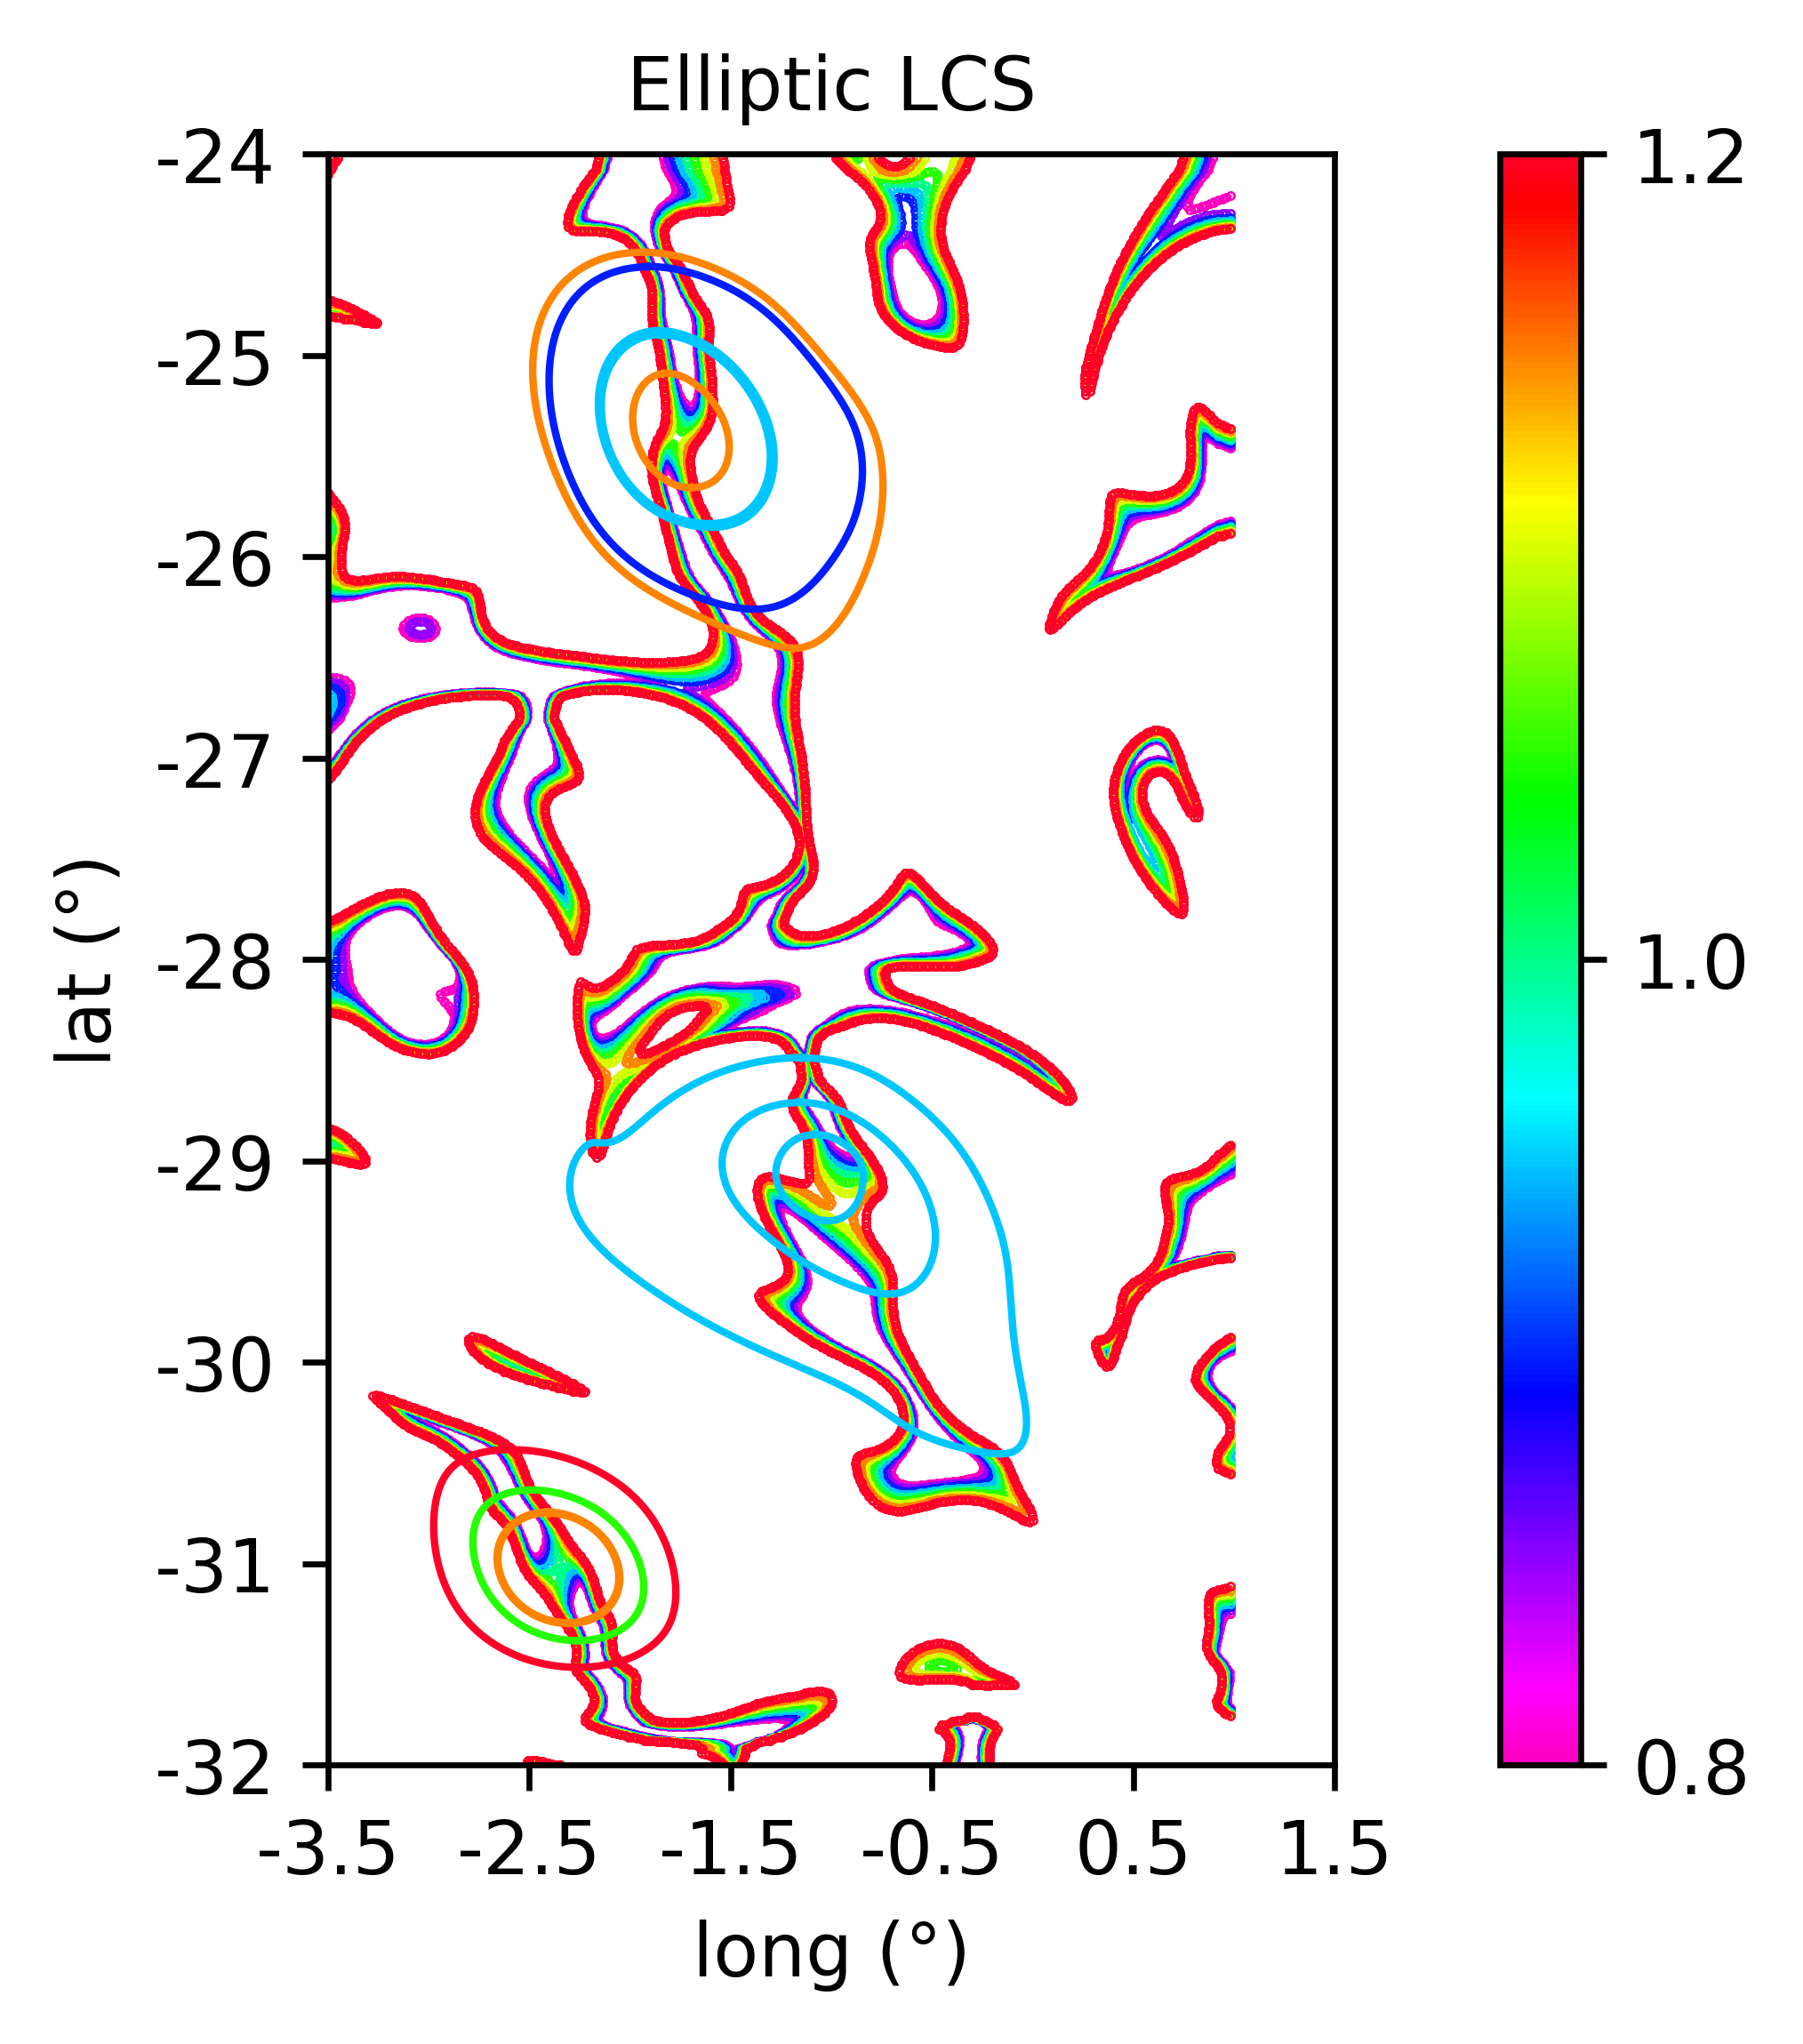

In [18]:
############################################ PLOT RESULTS ############################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=lam_range.min(), vmax=lam_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic LCS and plot
for i in range(len(Elliptic_LCS)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_LCS[i][2][0], Elliptic_LCS[i][2][1], color=cmap.to_rgba(lam_range[i]), s = 0.1)
    
    # Plot elliptic LCS
    if Elliptic_LCS[i][0] is not None:
        for j in range(len(Elliptic_LCS[i][0])):
            if Elliptic_LCS[i][0][j] is not None:
                ax.plot(Elliptic_LCS[i][0][j], Elliptic_LCS[i][1][j], c=cmap.to_rgba(lam_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Set ticks
ax.set_xticks(np.arange(xmin, xmax+1, 1))
ax.set_yticks(np.arange(ymin, ymax+1, 1))

# Set ticklabels
ax.set_xticklabels(np.arange(xmin, xmax+1, 1), fontsize = 10)
ax.set_yticklabels(np.arange(ymin, ymax+1, 1), fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[lam_range.min(), 1, lam_range.max()])

ax.set_aspect("equal")

# Title
ax.set_title("Elliptic LCS", fontsize = 10)
plt.show();

We obtain three objectively detected elliptic LCS families. The (colored) closed curves indicate elliptic LCS for different values of $ \lambda $. Furthermore, the initial conditions $ \mathbf{x}_0(\lambda, \phi_0 = 0) $ are also plotted as a function of $ \lambda $ (see colormap).

# Advect elliptic LCS

We now advect the computed elliptic LCS over a period of 25 days. The colored dashed lines denote the elliptic LCS computed at $ t_0 = 0$, whereas the colored solid lined indicate the same elliptic LCS advected after 25 days. As expected the detected elliptic LCS show coherent behaviour even after advection and barely deform.

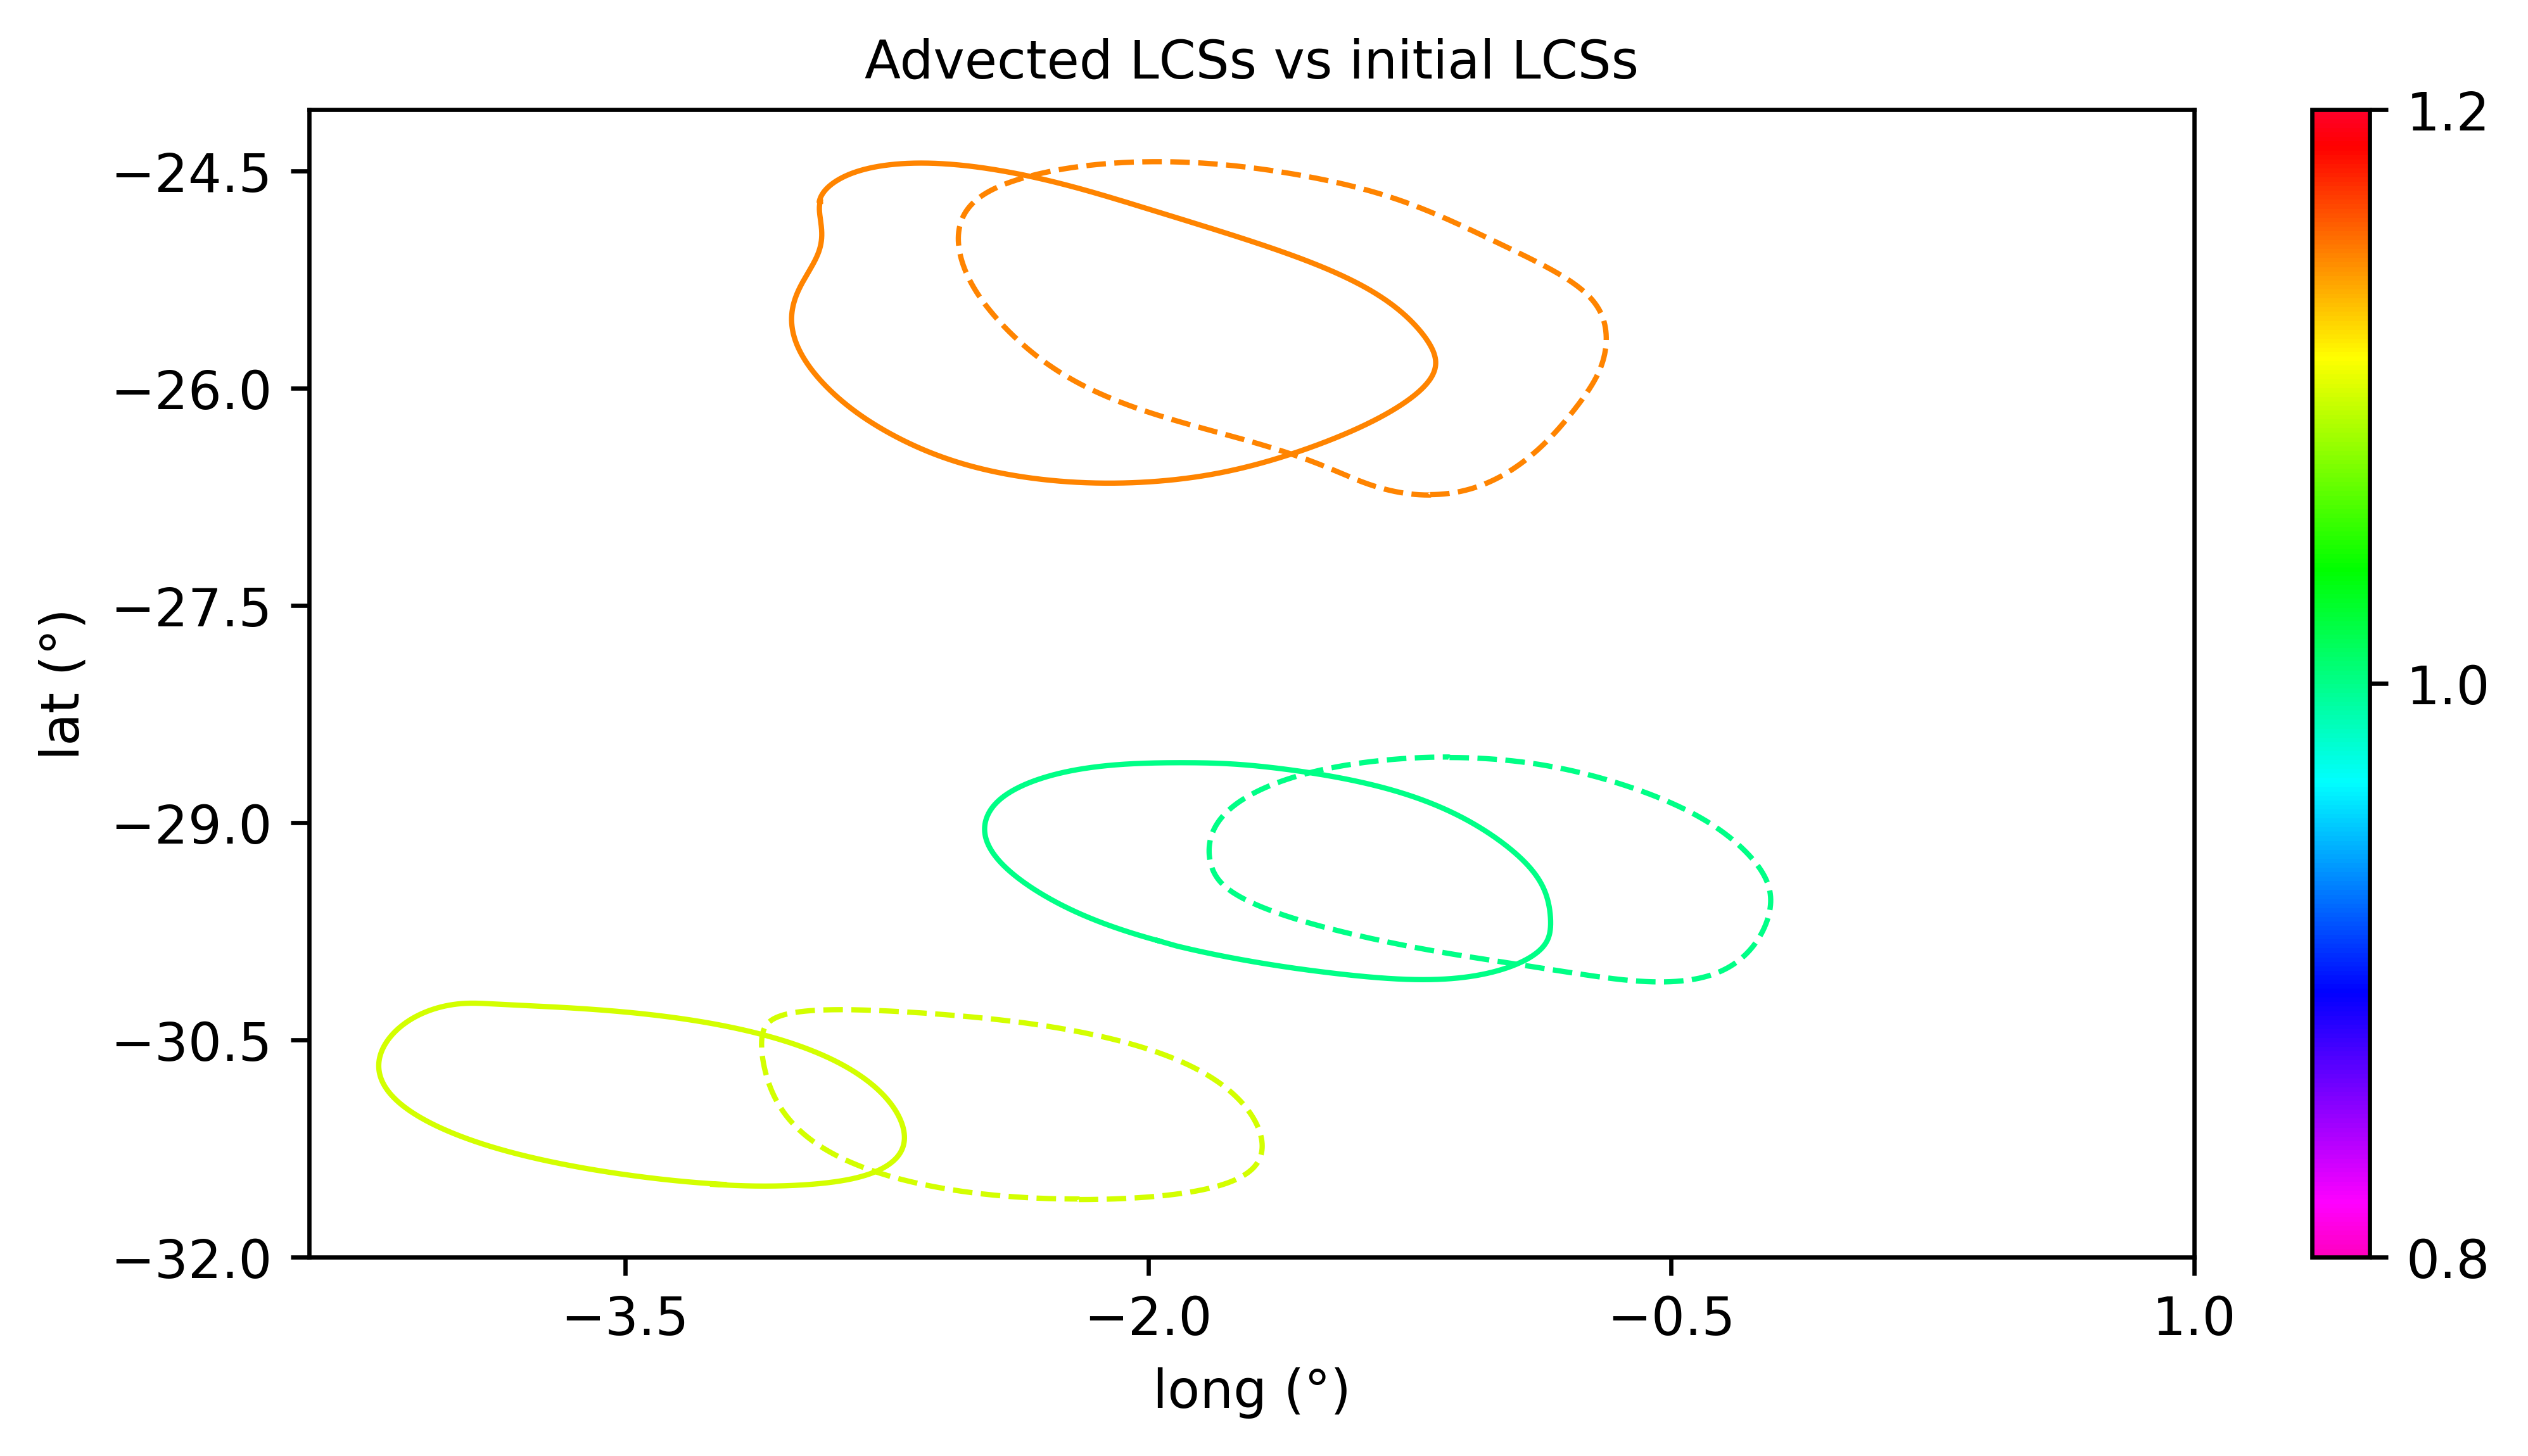

In [12]:
# Import function to compute trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# import function to extract outermost elliptic LCS for each family of elliptic LCS
from ipynb.fs.defs.find_outermost_closed_curve import find_outermost_closed_curve

# import function to suppress printing
from IPython.utils import io

# define time-horizon over which to advect
time_advect = time.copy()

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=lam_range.min(), vmax=lam_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# find outermost elliptic LCS in each family of elliptic LCS
x_outermost_elliptic_LCS, y_outermost_elliptic_LCS, lambda_outermost_elliptic_LCS = find_outermost_closed_curve(Elliptic_LCS, lam_range)

# Iterate over all elliptic LCS and plot
for i in range(len(x_outermost_elliptic_LCS)):
    
    # dummy plot
    ax.scatter(np.nan, np.nan, s = 1, color=cmap.to_rgba(lam_range[i]))
    
    ax.plot(x_outermost_elliptic_LCS[i], y_outermost_elliptic_LCS[i], c=cmap.to_rgba(lambda_outermost_elliptic_LCS[i]), linewidth = 1, linestyle = "dashed")
                    
    X0 = np.array([x_outermost_elliptic_LCS[i].ravel(), y_outermost_elliptic_LCS[i].ravel()])
                    
    # Advect Elliptic LCS
    with io.capture_output() as captured:
        Fmap = integration_dFdt(time_advect, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]

    # extract end-point of advection
    x_end = Fmap[:,-1]
                    
    x_advected = Fmap[-1,0,:]
    y_advected = Fmap[-1,1,:]
                    
    ax.plot(x_advected, y_advected, c=cmap.to_rgba(lambda_outermost_elliptic_LCS[i]), linewidth = 1)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1.5))
ax.set_yticks(np.arange(ymin, ymax+0.1, 1.5))
    
# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[lam_range.min(), 1, lam_range.max()])

# Title
ax.set_title("Advected LCSs vs initial LCSs", fontsize = 10)
plt.show();

# Elliptic LCS on FTLE

We now seek to find the outermost elliptic LCS within each family of elliptic LCSs. The extracted (outermost) elliptic LCSs are then plotted together with the $ \mathrm{FTLE} $.

In [13]:
# add FTLE folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE2D")

# Import function to compute Finite Time Lyapunov Exponent (FTLE) from CG tensor
from ipynb.fs.defs.FTLE import _FTLE_C

# Initialize FTLE
FTLE = C[0,0,:,:].copy()*np.nan

# Compute FTLE field
for i in range(FTLE.shape[0]):
    for j in range(FTLE.shape[1]):
        FTLE[i, j] = _FTLE_C(C[:, :, i, j], lenT)

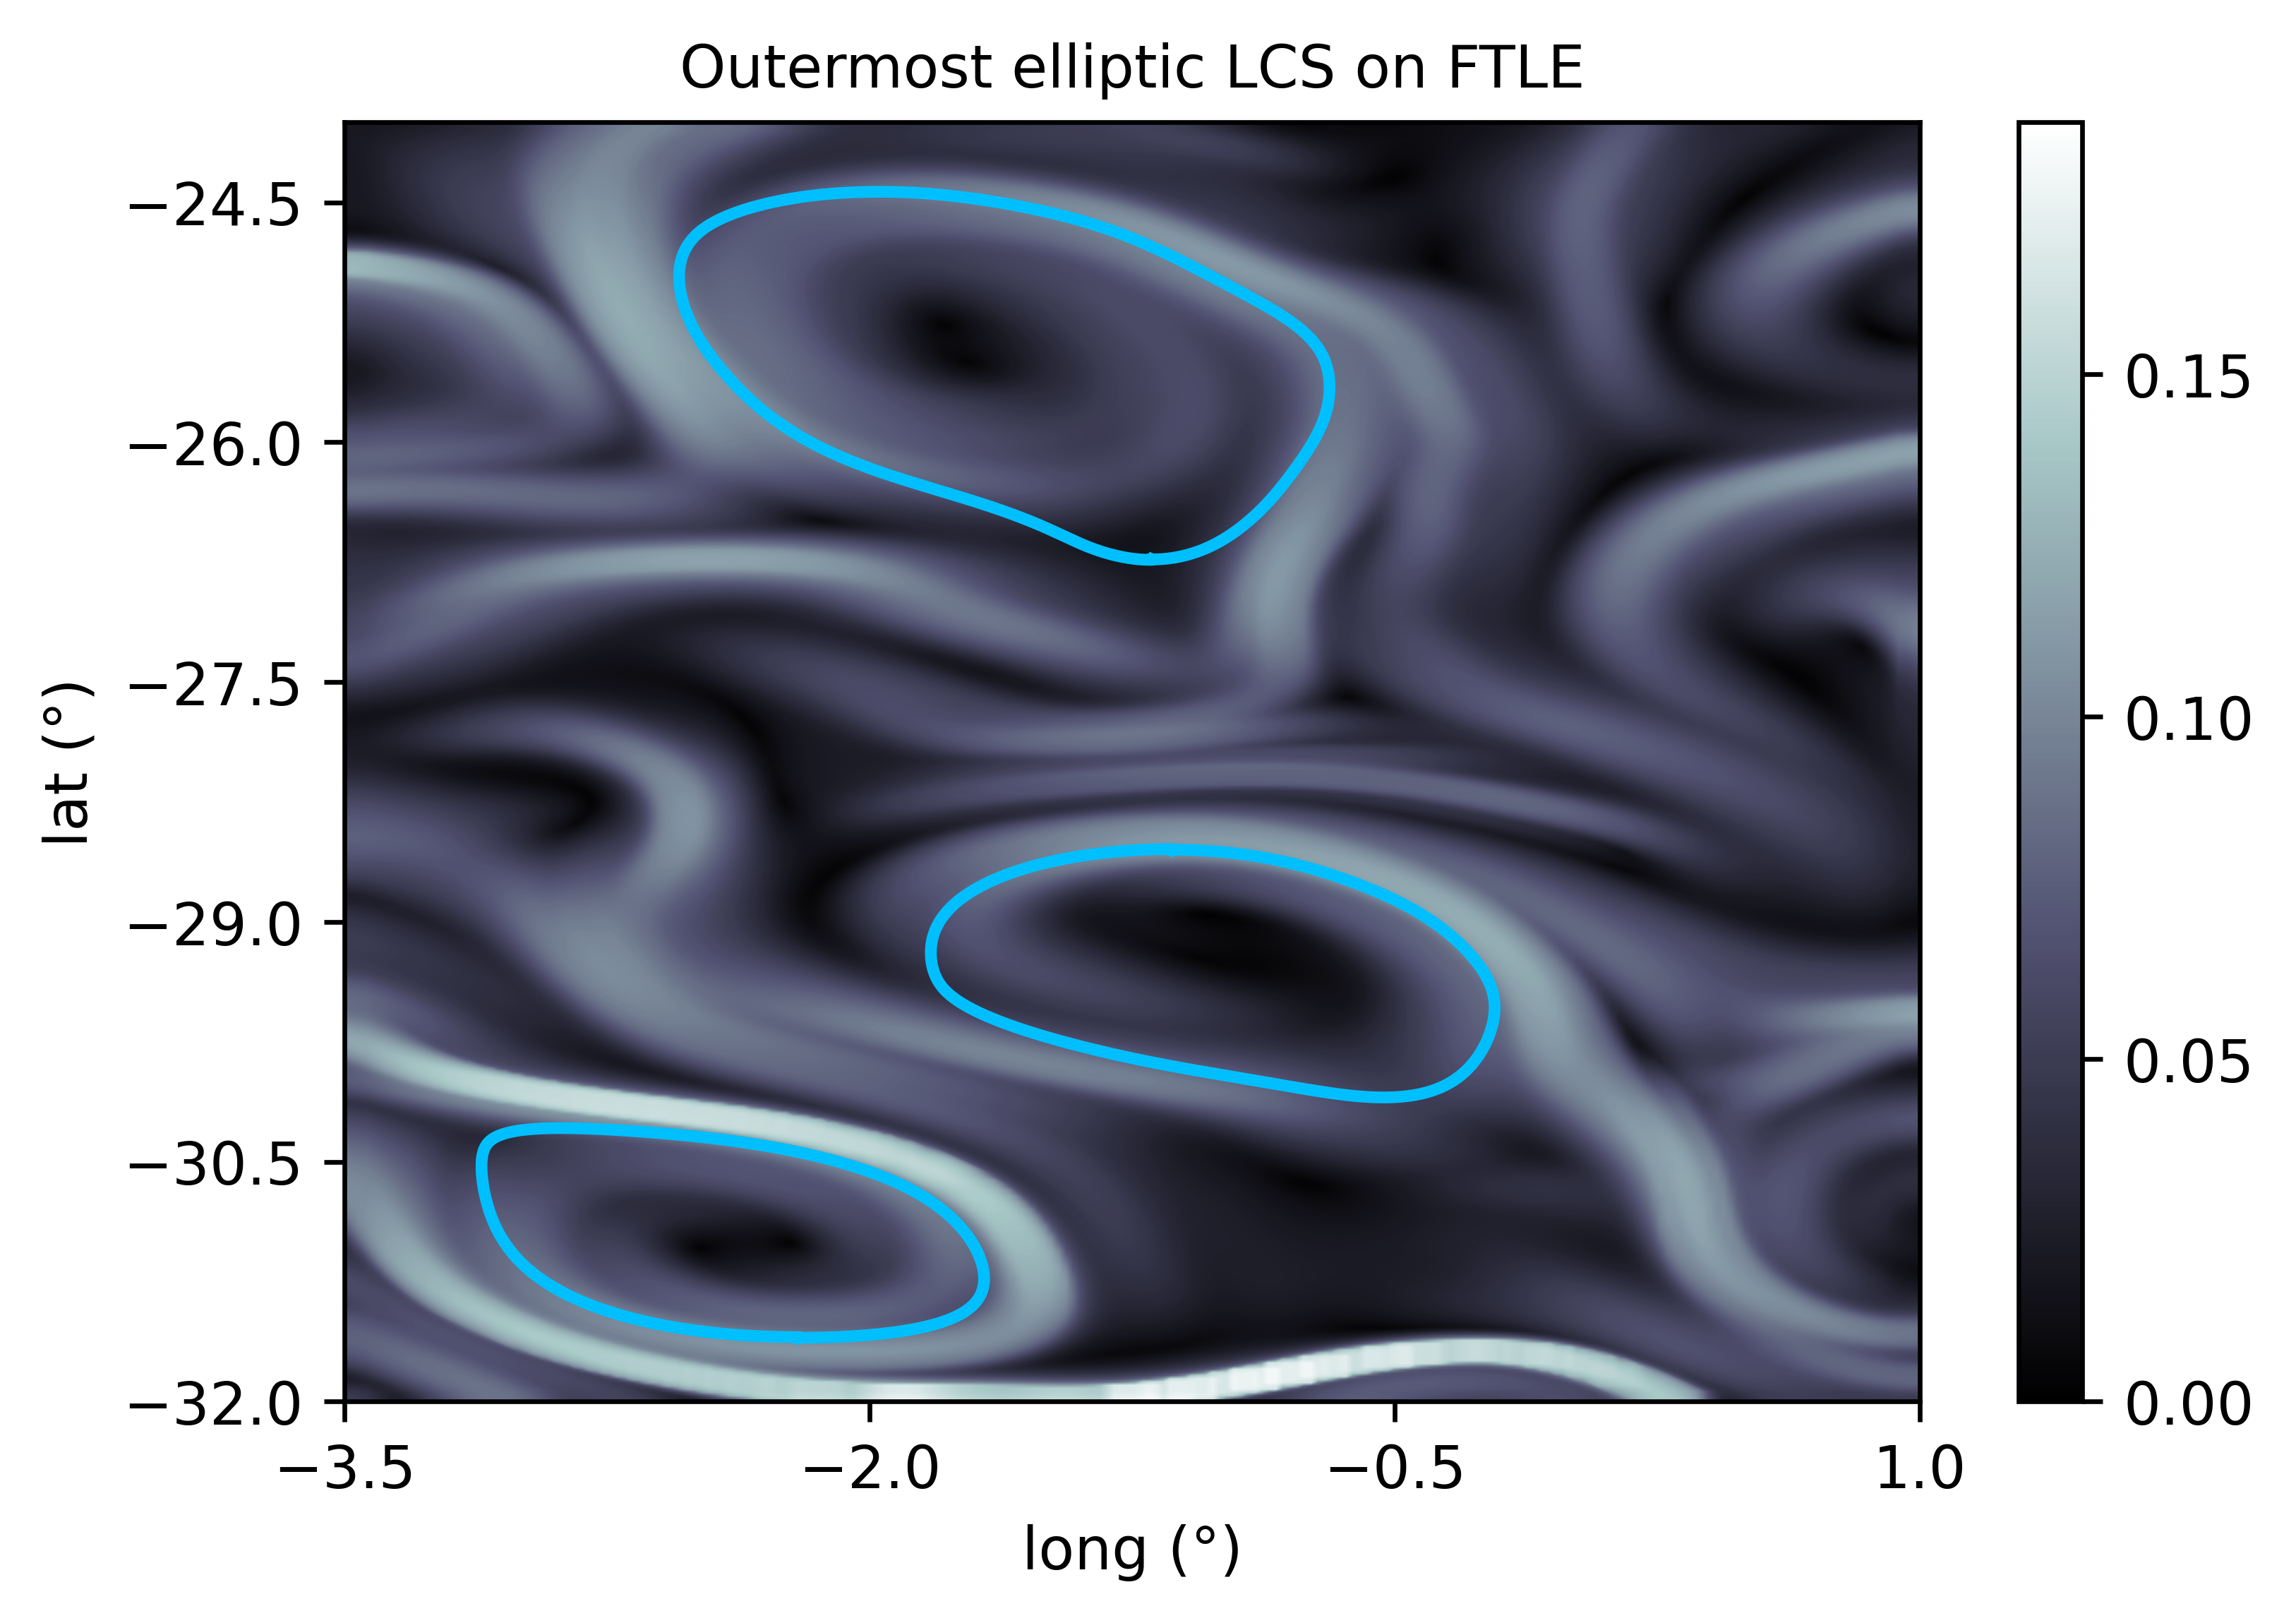

In [14]:
############################################ PLOT RESULTS ############################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define norm/cmap
# norm = mpl.colors.Normalize(vmin=lam_range.min(), vmax=lam_range.max())
# cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Define figure/axes
fig = plt.figure(dpi = 600)
ax = plt.axes()

# Iterate over all outermost elliptic LCS and plot
for i in range(len(x_outermost_elliptic_LCS)):
    ax.plot(x_outermost_elliptic_LCS[i], y_outermost_elliptic_LCS[i], c="deepskyblue", linewidth = 2)
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1.5))
ax.set_yticks(np.arange(ymin, ymax+0.1, 1.5))

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

cax = ax.contourf(X_domain, Y_domain, FTLE, cmap = "bone", levels = 600)

# Colorbar of FTLE
cbar = fig.colorbar(cax, ticks = np.arange(0, 0.4, 0.05))

# Title
ax.set_title("Outermost elliptic LCS on FTLE", fontsize = 10)
plt.show();

# References

[1] Serra, M., & Haller, G. (2017). Efficient computation of null geodesics with applications to coherent vortex detection. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 473(2199).

[2] Notebook 5.7. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.